In [1]:
import time
import pandas as pd
import numpy as np
import joblib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from dask_ml.wrappers import ParallelPostFit

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [2]:
%%time
df = pd.read_csv('../data/new_balanced_data_5.csv')
df.tail()

Wall time: 690 ms


,short_descriptions,assignment_groups
1376545,in not powerbi,grp_Atos_NGIT_Reporting
1376546,data for,grp_Atos_NGIT_Reporting
1376547,NaN,grp_Atos_NGIT_Reporting
1376548,NaN,grp_Atos_NGIT_Reporting
1376549,bi power,grp_Atos_NGIT_Reporting


In [3]:
vectorizer = joblib.load('../models/vectorizer')
encoder = joblib.load('../models/encoder')

In [4]:
df.isna().sum() / len(df) * 100

short_descriptions    23.758599
assignment_groups      0.000000
dtype: float64

In [5]:
df.fillna('', inplace=True)

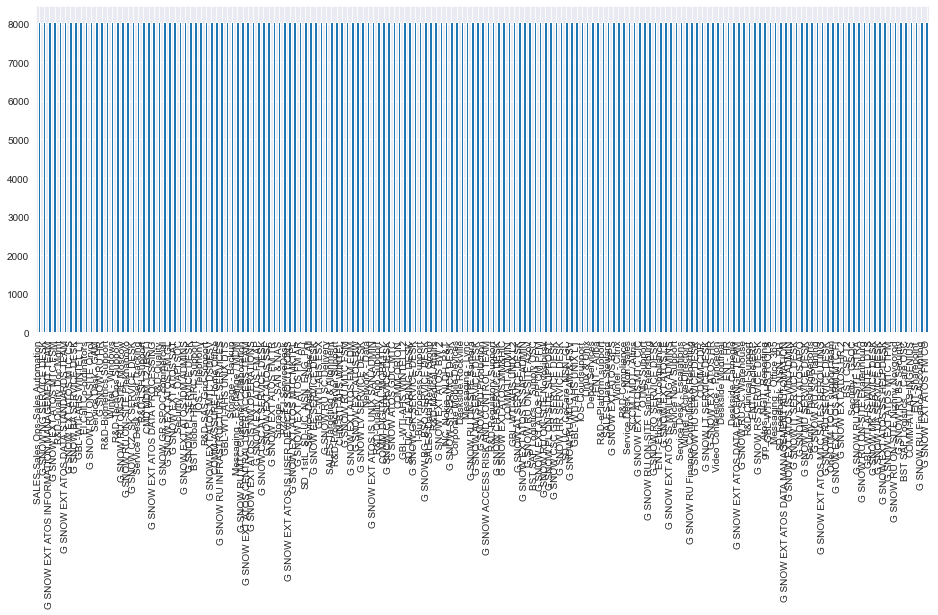

In [6]:
df['assignment_groups'].value_counts().plot(kind='bar', figsize=(16, 6))
plt.show()

In [7]:
X = df['short_descriptions'].values
y = df['assignment_groups'].values

In [8]:
X

array(['access for new employee', 'netscaler login issue',
       'hp printing nokia raleigh site 3rd floor printers fax function not working',
       ..., '', '', 'bi power'], dtype=object)

In [9]:
y

array(['G SNOW EXT ATOS CENTRAL USER ACCESS TEAM', 'Wintel - Citrix',
       'SD_1stL_SD-UC_NSN_ENG_PH', ..., 'grp_Atos_NGIT_Reporting',
       'grp_Atos_NGIT_Reporting', 'grp_Atos_NGIT_Reporting'], dtype=object)

In [10]:
%%time
X = vectorizer.transform(X)

Wall time: 7.21 s


In [11]:
%%time
y = encoder.transform(y.astype(str))

Wall time: 1.97 s


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1101240, 33492) (1101240,) (275310, 33492) (275310,)


In [14]:
models = [
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
#     RandomForestClassifier(n_jobs=-1),
#     LinearSVC(),
#     XGBClassifier(n_jobs=-1),
    DecisionTreeClassifier()
]


def display_metrics(true, pred):
    f1 = round(f1_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    precision = round(precision_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    recall = round(recall_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    acc = round(accuracy_score(y_true=y_test, y_pred=preds) * 100, 2)

    print(f'Acc: {acc}')
    print(f'F1: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

In [15]:
%%time

trained_models = dict()

for model in models:
    print(f'Training -> {model.__class__.__name__}')
    s = time.time()
    
    trained_models[model.__class__.__name__] = ParallelPostFit(
       estimator=model
    )
    
    trained_models[model.__class__.__name__].fit(X_train, y_train)
    
    e = time.time()
    
    preds = trained_models[model.__class__.__name__].predict(X_test)
    display_metrics(true=y_test, pred=preds)
    
    print(f'Training time: {round(e - s)} seconds')
    print('-' * 10)

Training -> MultinomialNB
Acc: 51.66
F1: 55.73
Precision: 72.96
Recall: 51.66
Training time: 3 seconds
----------
Training -> LogisticRegression
Acc: 56.74
F1: 62.8
Precision: 77.34
Recall: 56.74
Training time: 1481 seconds
----------
Training -> DecisionTreeClassifier
Acc: 58.88
F1: 65.06
Precision: 80.49
Recall: 58.88
Training time: 243 seconds
----------
Wall time: 28min 52s


In [23]:
import joblib

In [24]:
joblib.dump(trained_models['RandomForestClassifier'], '../models/randomforest.joblib', compress=2)

['../models/randomforest.joblib']

In [35]:
test = np.array([
    'HCP restriction removal'
])
test = vectorizer.transform(test)

In [36]:
prediction = trained_models['RandomForestClassifier'].predict(test)

In [38]:
encoder.inverse_transform(prediction)[0]

'Service Desk - Sales All'